<a href="https://colab.research.google.com/github/vittorioyes/test/blob/main/2301_pir_quali_azioni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance --upgrade --no-cache-dir

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

#tickers = ["^gspc", "^SP500TR", "EURusd=X", "BRK-B", "acn", "MKL", "L", "BAM", "FRFHF", "BX", "KKR", "APO",
 #          "III.L", "CLDN.L", "RCP.L", 'CIR.MI', 'TIP.MI']  # Lista di azioni varie

tickers = ["^gspc", "^SP500TR", "EURusd=X", "BRK-B", "acn", "KO", "BAM", "JNJ", 'KHC', 'MKL','PARA', "ENEL.MI", "ACE.MI"] # Lista di Azioni che mi piacciono

#tickers = ['ABDN.L', 'III.L','CLDN.L', 'RCP.L', 'WTAN.L'] #lista di holding inglesi


# Funzione per calcolare il CAGR
def calculate_cagr(first_close, last_close, start_date, end_date):
    years = (end_date - start_date).days / 365.25  # Calcola il numero di anni
    cagr = ((last_close / first_close) ** (1 / years)) - 1  # Formula CAGR
    return cagr * 100  # Restituisci il CAGR in percentuale

def calculate_annual_dividend_yield(ticker, last_close):
    if last_close == 0:
        return None  # Avoid division by zero
    try:
        ticker_data = yf.Ticker(ticker)
        dividends = ticker_data.dividends
        if not dividends.empty:
            # Get dividends from the last 12 months
            last_12_months = datetime.now() - timedelta(days=365)
            recent_dividends = dividends[dividends.index.tz_localize(None) >= last_12_months]
            total_dividends = recent_dividends.sum()
            dividend_yield = (total_dividends / last_close) * 100
            return dividend_yield
        else:
            return None  # No dividend data available
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def calculate_roe(ticker):
    try:
        # Ottieni i dati finanziari dell'azienda
        stock = yf.Ticker(ticker)

        # Ottieni il bilancio dell'azienda
        financials = stock.financials
        balance_sheet = stock.balance_sheet

        # Verifica se ci sono dati disponibili
        if financials.empty or balance_sheet.empty:
            print("Dati finanziari non disponibili.")
            return None

        # Ottieni l'utile netto dell'ultimo anno
        net_income = financials.loc['Net Income'].iloc[0]

        # Ottieni il patrimonio netto (equity) dell'ultimo anno Stockholders Equity
        total_equity = balance_sheet.loc['Stockholders Equity'].iloc[0]

        # Calcola il ROE
        roe = (net_income / total_equity) * 100

        return roe
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def get_company_long_name(ticker):
    try:
        # Crea un oggetto Ticker per l'azienda
        stock = yf.Ticker(ticker)

        # Ottieni le informazioni generali dell'azienda
        company_info = stock.info

        # Verifica se il longName è presente
        if 'longName' in company_info:
            long_name = company_info['longName']
            short_name = long_name[:10]  # Limita alle prime 10 lettere
            return short_name
        else:
            print(f"Nome completo non disponibile per il ticker {ticker}.")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def calculate_distance_from_200_week_ma(ticker):
    try:
        # Ottieni i dati storici delle ultime 10 anni (in settimane servono almeno 5 anni, ma aggiungiamo margine)
        stock = yf.Ticker(ticker)
        historical_data = stock.history(period="max", interval="1wk")  # Dati settimanali per 10 anni

        # Verifica se ci sono dati disponibili
        if historical_data.empty:
            print(f"Nessun dato disponibile per {ticker}.")
            return None

        # Calcola la media mobile a 200 settimane
        historical_data['200_Week_MA'] = historical_data['Close'].rolling(window=200).mean()

        # Prendi l'ultimo prezzo di chiusura settimanale
        last_close = historical_data['Close'].iloc[-1]

        # Prendi l'ultima media mobile a 200 settimane
        ma_200_week = historical_data['200_Week_MA'].iloc[-1]

        # Calcola la distanza in valore assoluto e percentuale
        distance_absolute = last_close - ma_200_week
        distance_percent = (distance_absolute / ma_200_week) * 100

        return distance_percent

    except Exception as e:
        print(f"An error occurred: {e}")
        return None





# DataFrame per memorizzare i risultati
results = pd.DataFrame(columns=['Ticker', 'Nome', 'Crescita (%)', 'CAGR (%)', 'Yield (%)', 'ROE', '200-week'])

for ticker in tickers:
    start_date = datetime(2014, 1, 1)
    end_date = datetime.now()

    # Scarica i dati storici
    try:
        sp500_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

        if sp500_data.empty:
            print(f"Nessun dato disponibile per {ticker}.")
            continue

        first_close = sp500_data['Close'].iloc[0]
        last_close = sp500_data['Close'].iloc[-1]

        growth_percentage = ((last_close - first_close) / first_close) * 100
        cagr = calculate_cagr(first_close, last_close, start_date, end_date)
        dividend_yield = calculate_annual_dividend_yield(ticker, last_close)
        #roe = calculate_roe(ticker)

        # Aggiungi i risultati al DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Ticker': [ticker],
            'Nome': [get_company_long_name(ticker)],
            'Crescita (%)': [growth_percentage],
            'CAGR (%)': [f'{cagr:.2f}'],
            'Yield (%)': [f'{dividend_yield:.2f}' if dividend_yield is not None else 0],
            'ROE': [calculate_roe(ticker)],
            '200-week': [calculate_distance_from_200_week_ma(ticker)] # Sostituisci con 0 se non ci sono dividendi
        })], ignore_index=True)

    except Exception as e:
        print(f"Si è verificato un errore per {ticker}: {e}")

# Visualizza i risultati
print(results)

eurusd_data = yf.download("EURusd=X", start=start_date, end=end_date, progress=False)
if not eurusd_data.empty:
    first_close = eurusd_data['Close'].iloc[0]
    last_close = eurusd_data['Close'].iloc[-1]
    print(f"\nValore di EUR/USD al {start_date}: {first_close:.4f}")
    print(f"Valore di EUR/USD oggi {last_close:.4f}")
else:
    print(f"Nessun dato disponibile per {ticker} al {start_date}.")


Dati finanziari non disponibili.


<ipython-input-3-baf56ad27da4>:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Dati finanziari non disponibili.
Dati finanziari non disponibili.


<ipython-input-3-baf56ad27da4>:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


      Ticker        Nome  Crescita (%) CAGR (%) Yield (%)        ROE  \
0      ^gspc     S&P 500    218.915615    11.34         0        NaN   
1   ^SP500TR  S&P 500 (T    289.170870    13.42         0        NaN   
2   EURusd=X     EUR/USD    -20.813691    -2.14         0        NaN   
3      BRK-B  Berkshire     296.331917    13.61         0  17.143707   
4        acn  Accenture     358.843858    15.16      1.44  25.680929   
5         KO  The Coca-C     73.561239     5.24      2.71  41.301415   
6        BAM  Brookfield     57.124996     4.28      2.90  21.628131   
7        JNJ  Johnson &      80.467979     5.62      2.96  51.113793   
8        KHC  The Kraft     -50.918309    -6.38      4.47   5.764649   
9        MKL  Markel Gro    174.030446     9.79         0  13.321340   
10      PARA  Paramount     -83.367588   -15.31      1.90  -2.699103   
11   ENEL.MI    Enel SpA    130.025525     8.02      5.96  10.826641   
12    ACE.MI  ACEA S.p.A    114.716518     7.34      4.94  12.36

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def calculate_annual_dividend_yield(ticker):
    # Scarica i dati del ticker
    ticker_data = yf.Ticker(ticker)

    # Ottieni l'ultimo prezzo di chiusura
    last_close = ticker_data.history(period='1d')['Close'].iloc[-1]

    # Ottieni i dividendi distribuiti negli ultimi 12 mesi
    dividends = ticker_data.dividends

    if not dividends.empty:
        # Considera solo i dividendi degli ultimi 12 mesi
        last_12_months = pd.Timestamp(datetime.now() - timedelta(days=365))
        recent_dividends = dividends[dividends.index >= last_12_months]
        total_dividends = recent_dividends.sum()  # Somma tutti i dividendi negli ultimi 12 mesi

        # Calcola il rendimento da dividendo annualizzato
        dividend_yield = (total_dividends / last_close) * 100  # Rendimento come percentuale
        return dividend_yield
    else:
        return None  # Nessun dividendo disponibile

# Esempio di utilizzo
ticker = "Acn"  # Cambia questo ticker con quello desiderato
annual_yield = calculate_annual_dividend_yield(ticker)

if annual_yield is not None:
    print(f"Il rendimento annuale da dividendi per {ticker} è: {annual_yield:.2f}%")
else:
    print(f"Nessun dividendo disponibile per {ticker}.")


Nessun dividendo disponibile per Acn.


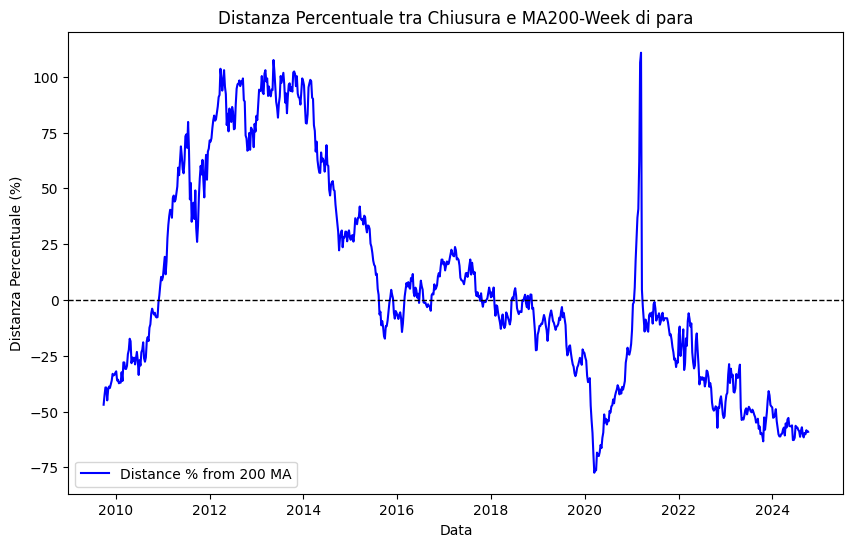

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

ticker = "para"

data = yf.download(ticker, period="max", interval="1wk", progress=False)

# Calcola la media mobile a 200 giorni
data['200_MA'] = data['Close'].rolling(window=200).mean()

# Calcola la distanza percentuale tra il prezzo di chiusura e la media mobile a 200 giorni
data['Distance %'] = ((data['Close'] - data['200_MA']) / data['200_MA']) * 100

# Crea il grafico della distanza percentuale
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Distance %'], label='Distance % from 200 MA', color='blue')

# Imposta titolo e etichette
plt.title(f'Distanza Percentuale tra Chiusura e MA200-Week di {ticker}')
plt.xlabel('Data')
plt.ylabel('Distanza Percentuale (%)')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Linea di riferimento allo 0%

# Mostra la leggenda
plt.legend()

# Mostra il grafico
plt.show()


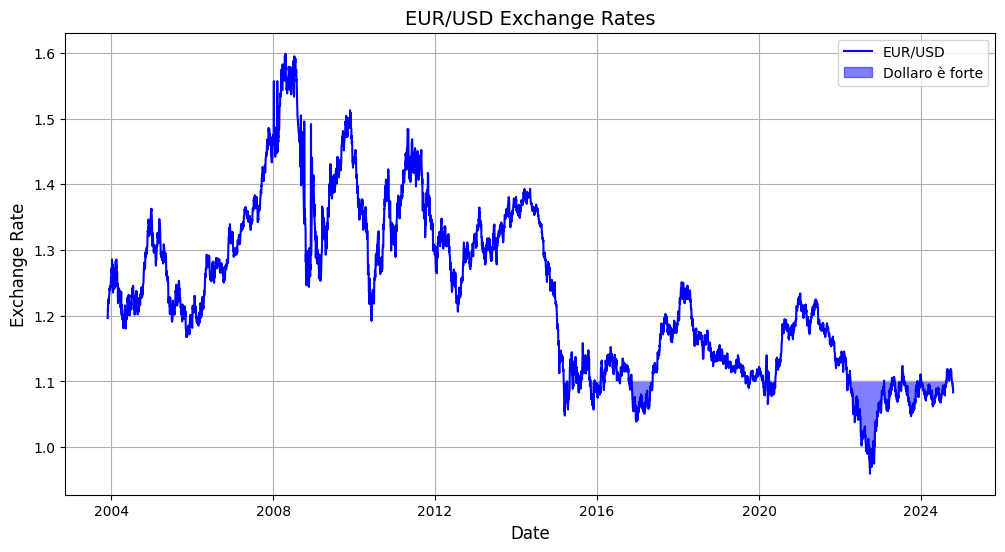

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Scarica i dati storici per EUR/USD e EUR/GBP per gli ultimi 10 anni
eur_usd_ticker = 'EURUSD=X'
eur_gbp_ticker = 'eurGBP=X'

eur_usd = yf.Ticker(eur_usd_ticker)
eur_gbp = yf.Ticker(eur_gbp_ticker)

data_eur_usd = eur_usd.history(period='max')
data_eur_gbp = eur_gbp.history(period="max")

# Crea il grafico
plt.figure(figsize=(12, 6))

# Grafico EUR/USD
plt.plot(data_eur_usd.index, data_eur_usd['Close'], label='EUR/USD', color='blue')

level = 1.1  # Set the level you want to shade
plt.fill_between(data_eur_usd.index, level, data_eur_usd['Close'], where=(data_eur_usd['Close'] < level),
                 color='blue', alpha=0.5, label='Dollaro è forte')


# Grafico EUR/GBP
#plt.plot(data_eur_gbp.index, data_eur_gbp['Close'], label='EUR/GBP', color='green')

# Titolo e etichette
plt.title('EUR/USD Exchange Rates', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.grid(True)
plt.legend()

# Mostra il grafico
plt.show()



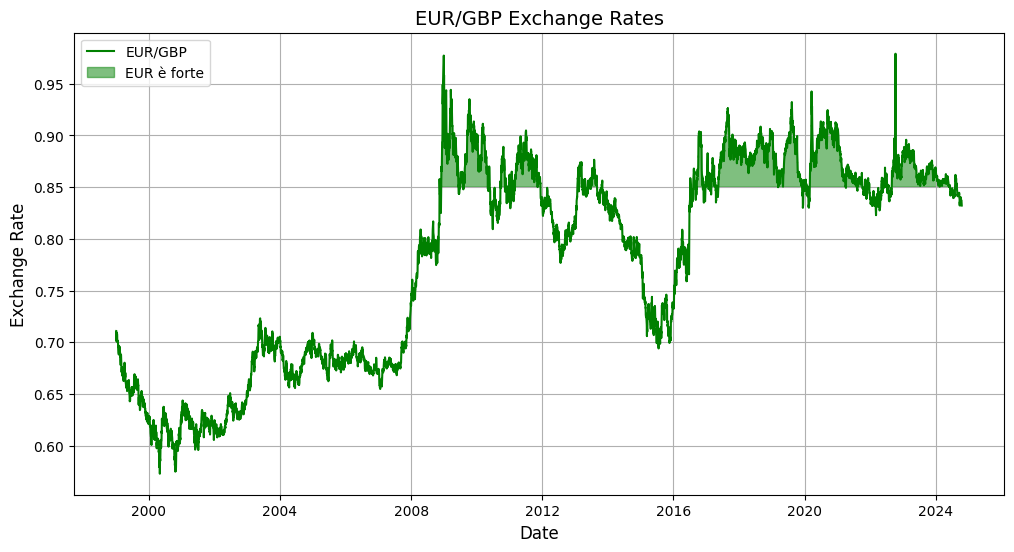

1 sterlina : 2327 lire


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

eur_gbp_ticker = 'eurGBP=X'

eur_gbp = yf.Ticker(eur_gbp_ticker)

data_eur_gbp = eur_gbp.history(period="max")

plt.figure(figsize=(12, 6))

plt.plot(data_eur_gbp.index, data_eur_gbp['Close'], label='EUR/GBP', color='green')

# Shade the area above the indicated level in light gray
level = 0.85  # Set the level you want to shade
plt.fill_between(data_eur_gbp.index, level, data_eur_gbp['Close'], where=(data_eur_gbp['Close'] > level),
                 color='green', alpha=0.5, label='EUR è forte')

plt.title('EUR/GBP Exchange Rates', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.grid(True)
plt.legend()

plt.show()

last_gbp = data_eur_gbp['Close'].iloc[-1]
last_lire = 1936.27 / last_gbp
print(f"1 sterlina : {last_lire:.0f} lire")

In [ ]:
import yfinance as yf
import pandas as pd


ticker = "MKL"

# Scarica i dati storici
data = yf.download(ticker, period='max', interval='1d', progress=False)


# Converte l'indice della data in formato 'datetime'
data.index = pd.to_datetime(data.index)

# Calcola il rendimento annuale
annual_returns = {}

for year in range(data.index.year.min(), data.index.year.max() + 1):
    # Filtra i dati per l'anno corrente
    year_data = data[data.index.year == year]

    if not year_data.empty:
        # Prezzo di chiusura del primo e ultimo giorno dell'anno
        first_close = year_data['Close'].iloc[0]
        last_close = year_data['Close'].iloc[-1]

        # Calcola la percentuale di rendimento per l'anno
        annual_return = ((last_close - first_close) / first_close) * 100

        # Aggiunge il risultato al dizionario
        annual_returns[year] = round(annual_return, 2)

# Stampa i rendimenti annuali
for year, return_percentage in annual_returns.items():
    print(f"Anno {year}: Rendimento {return_percentage:.2f} %")


Anno 1986: Rendimento -2.50 %
Anno 1987: Rendimento 41.03 %
Anno 1988: Rendimento 32.14 %
Anno 1989: Rendimento 18.42 %
Anno 1990: Rendimento -47.19 %
Anno 1991: Rendimento 100.00 %
Anno 1992: Rendimento 46.20 %
Anno 1993: Rendimento 26.00 %
Anno 1994: Rendimento 7.79 %
Anno 1995: Rendimento 81.93 %
Anno 1996: Rendimento 19.21 %
Anno 1997: Rendimento 69.70 %
Anno 1998: Rendimento 16.03 %
Anno 1999: Rendimento -14.34 %
Anno 2000: Rendimento 21.58 %
Anno 2001: Rendimento 2.95 %
Anno 2002: Rendimento 15.77 %
Anno 2003: Rendimento 19.58 %
Anno 2004: Rendimento 42.47 %
Anno 2005: Rendimento -13.02 %
Anno 2006: Rendimento 50.27 %
Anno 2007: Rendimento 2.68 %
Anno 2008: Rendimento -37.30 %
Anno 2009: Rendimento 14.90 %
Anno 2010: Rendimento 11.94 %
Anno 2011: Rendimento 6.26 %
Anno 2012: Rendimento 4.73 %
Anno 2013: Rendimento 32.19 %
Anno 2014: Rendimento 18.81 %
Anno 2015: Rendimento 29.70 %
Anno 2016: Rendimento 4.39 %
Anno 2017: Rendimento 24.81 %
Anno 2018: Rendimento -7.01 %
Anno 2019: 

In [ ]:
import yfinance as yf
from datetime import datetime

def calculate_cagr(ticker):
    # Scarica i dati storici per il periodo massimo disponibile
    data = yf.download(ticker, period='5y', progress=False)

    start_of_year = datetime(datetime.today().year, 1, 1)
    #data = yf.download(ticker, start=start_of_year, progress=False)

    # Calcola il primo e l'ultimo prezzo di chiusura
    first_close = data['Close'].iloc[0]
    last_close = data['Close'].iloc[-1]

    # Calcola il numero di anni tra il primo e l'ultimo dato
    years = (data.index[-1] - data.index[0]).days / 365.25

    # Calcola il CAGR
    cagr = ((last_close / first_close) ** (1 / years) - 1) * 100

    # Stampa il CAGR
    print(f"CAGR {years} anni {ticker}: {cagr:.2f}%")

tickers=["^sp500tr", "acn", "brk-b", 'mkl', "ko", 'KHC',"enel.mi", "eni.mi", "trn.mi", 'pst.mi', "nvda", "amzn", "tsco.l", "vusa.mi", 'VHYL.MI']

for a in tickers:
    calculate_cagr(a)


CAGR 5.002053388090349 anni ^sp500tr: 16.33%
CAGR 5.002053388090349 anni acn: 14.47%
CAGR 5.002053388090349 anni brk-b: 17.03%
CAGR 5.002053388090349 anni mkl: 6.47%
CAGR 5.002053388090349 anni ko: 5.22%
CAGR 5.002053388090349 anni KHC: 5.27%
CAGR 5.002053388090349 anni enel.mi: 0.64%
CAGR 5.002053388090349 anni eni.mi: 0.86%
CAGR 5.002053388090349 anni trn.mi: 6.48%
CAGR 5.002053388090349 anni pst.mi: 4.43%
CAGR 5.002053388090349 anni nvda: 96.49%
CAGR 5.002053388090349 anni amzn: 16.77%
CAGR 5.002053388090349 anni tsco.l: 4.52%
CAGR 5.002053388090349 anni vusa.mi: 14.56%
CAGR 5.002053388090349 anni VHYL.MI: 5.53%


In [ ]:
import yfinance as yf
import pandas as pd

# Definisci il ticker per Accenture
ticker = "ACN"

acn_data = yf.download(ticker, period='1d', progress=False)

acn_data['200_MA'] = acn_data['Close'].rolling(window=200).mean()

last_close = acn_data['Close'].iloc[-1]
last_ma_200 = acn_data['200_MA'].iloc[-1]

distance_percentage = ((last_close - last_ma_200) / last_ma_200) * 100

# Stampa i risultati
print(f"Ultimo prezzo di chiusura per {ticker}: {last_close:.2f}")
print(f"Ultimo valore della Media Mobile a 200 giorni per {ticker}: {last_ma_200:.2f}")
print(f"Distanza percentuale dall'ultimo prezzo alla Media Mobile a 200 giorni: {distance_percentage:.2f}%")


Ultimo prezzo di chiusura per ACN: 356.80
Ultimo valore della Media Mobile a 200 giorni per ACN: nan
Distanza percentuale dall'ultimo prezzo alla Media Mobile a 200 giorni: nan%


In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8eaa156839e1ef58301f8ea96c3ad51982f68b858a18999628c2a8c628242b30
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# TURTLE TRADING: segnale di BreakOut 20 giorni

import pandas as pd
import yfinance as yf
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator

# Lista di ticker di azioni
tickers = ['ADB.MI','ACE.MI','AKZA.AS','ENI.MI', 'ERG.MI', 'UNI.MI', 'VHYL.MI','TSCO.L','VOD.L', 'ACN','OXY', 'KHC', 'TEAM']
rischio = 500

# Creazione del DataFrame
data = pd.DataFrame(columns=['Ticker', 'Close'])

for ticker in tickers:
    # Recupero dei dati dal servizio yfinance
    ticker_data = yf.Ticker(ticker)

    # Recupero dei dati storici
    history = ticker_data.history(period='1mo')

    last_20_days = history.iloc[-21:-1]

    # Calcolo del massimo High degli ultimi 20 giorni
    highest_high_20 = last_20_days['High'].max().round(2)

    last_close = history['Close'].iloc[-1]

    # Determinare se l'ultimo Close è maggiore del più alto High degli ultimi 20 giorni
    if last_close > highest_high_20:
        result = 'Yes'
    else:
        result = 'No'

    # Calcolo dell'Average True Range (ATR)
    atr = AverageTrueRange(high=history['High'], low=history['Low'], close=history['Close'], window=20)
    atr_value = atr.average_true_range().round(2)
    variazione = atr_value * 2
    last_close = last_close.round(2)
    stop_loss = last_close - variazione
    stop_loss = stop_loss.round(2)
    azioni = rischio/variazione
    azioni = azioni.round(0)
    capitale = azioni * last_close
    capitale = capitale.round(0)

    # Creazione di un DataFrame per il ticker corrente
    ticker_df = pd.DataFrame({'Ticker': ticker,
                              'Close': last_close,
                              'High 20': highest_high_20,
                              'BreakOut': result,
                              #'ATR': atr_value.iloc[-1],
                              '2N': variazione.iloc[-1],
                              'Stop Loss': stop_loss.iloc[-1],
                              'Azioni' : azioni.iloc[-1],
                              'Capitale' : capitale.iloc[-1]}, index=[0])

    # Concatenazione del DataFrame corrente con il DataFrame principale
    data = pd.concat([data, ticker_df], ignore_index=True)

# Visualizzazione del DataFrame
print()
print(data)
print()


<ipython-input-9-7ccfa415ef85>:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, ticker_df], ignore_index=True)



     Ticker   Close  High 20 BreakOut     2N  Stop Loss  Azioni  Capitale
0    ADB.MI    7.78     7.88       No   0.22       7.56  2273.0   17684.0
1    ACE.MI   17.34    17.58       No   0.52      16.82   962.0   16681.0
2   AKZA.AS   57.62    59.16       No   1.72      55.90   291.0   16767.0
3    ENI.MI   13.78    14.91       No   0.42      13.36  1190.0   16398.0
4    ERG.MI   24.90    25.42       No   0.84      24.06   595.0   14816.0
5    UNI.MI    9.48     9.76       No   0.38       9.10  1316.0   12476.0
6   VHYL.MI   61.15    63.11       No   0.94      60.21   532.0   32532.0
7    TSCO.L  368.12   369.70       No   8.88     359.24    56.0   20615.0
8     VOD.L   76.42    78.64       No   2.60      73.82   192.0   14673.0
9       ACN  345.30   350.72       No  10.54     334.76    47.0   16229.0
10      OXY   51.02    58.22       No   2.26      48.76   221.0   11275.0
11      KHC   34.87    36.53       No   1.14      33.73   439.0   15308.0
12     TEAM  166.63   169.72       No

In [ ]:
# TURTLE TRADING: segnale di BreakOut 10 giorni per uscire da Long

# Lista di ticker di azioni
tickers = ['ACN', 'UNI.MI', 'VOD.L']

# Creazione del DataFrame
data = pd.DataFrame(columns=['Ticker','Close'])

for ticker in tickers:
    # Recupero dei dati dal servizio yfinance
    ticker_data = yf.Ticker(ticker)

    # Recupero dei dati storici
    history = ticker_data.history(period='1mo')

    last_10_days = history.iloc[-11:-1]

    # Calcolo del massimo Low degli ultimi 10 giorni
    low_10 = last_10_days['Low'].min().round(2)

    last_close = history['Close'].iloc[-1].round(2)

    # Determinare se l'ultimo Close è minore del più basso Low degli ultimi 10 giorni
    if last_close < low_10:
        result = 'Yes'
    else:
        result = 'No'

#    last_close = last_close.round(2)

    # Creazione di un DataFrame per il ticker corrente
    ticker_df = pd.DataFrame({'Ticker': ticker,
                              'Close': last_close,
                              'Low 10': low_10,
                              'SELL': result}, index=[0])
                              #'ATR': atr_value.iloc[-1],
                              #'2N': variazione.iloc[-1],
                              #'Stop Loss': stop_loss.iloc[-1],
                              #'Azioni' : azioni.iloc[-1],
                              #'Capitale' : capitale.iloc[-1]}, index=[0])

    # Concatenazione del DataFrame corrente con il DataFrame principale
    data = pd.concat([data, ticker_df], ignore_index=True)

# Visualizzazione del DataFrame
print()
print(data)
print()


   Ticker   Close  Low 10 SELL
0     ACN  374.78  358.97   No
1  UNI.MI    7.50    6.48   No
2   VOD.L   70.77   63.81   No



In [ ]:
# Recupero dei dati dal servizio yfinance
ticker_1 = "ADB.MI"

ticker_data = yf.Ticker(ticker_1)

# Recupero dei dati storici per 3 mesi
history = ticker_data.history(period='3mo')

#Definisco il periodo di visualizzazione (es. ultimi 20 gg)
periodo = history.iloc[-21:-1]

print(periodo)


                           Open  High   Low  Close  Volume  Dividends  \
Date                                                                    
2024-01-30 00:00:00+01:00  8.24  8.26  8.14   8.26    2950        0.0   
2024-01-31 00:00:00+01:00  8.26  8.26  8.16   8.16    5083        0.0   
2024-02-01 00:00:00+01:00  8.24  8.24  8.14   8.22    2526        0.0   
2024-02-02 00:00:00+01:00  8.16  8.22  8.14   8.22    1178        0.0   
2024-02-05 00:00:00+01:00  8.16  8.22  8.14   8.20     324        0.0   
2024-02-06 00:00:00+01:00  8.14  8.18  8.08   8.18    4899        0.0   
2024-02-07 00:00:00+01:00  8.10  8.22  8.08   8.20    5528        0.0   
2024-02-08 00:00:00+01:00  8.20  8.20  8.10   8.18    2958        0.0   
2024-02-09 00:00:00+01:00  8.10  8.18  8.04   8.18    3192        0.0   
2024-02-12 00:00:00+01:00  8.18  8.18  7.88   8.02    5514        0.0   
2024-02-13 00:00:00+01:00  8.00  8.14  7.78   7.98    7991        0.0   
2024-02-14 00:00:00+01:00  8.00  8.04  7.84   8.04 

In [ ]:
import yfinance as yf

def calculate_roe(ticker):
    try:
        # Ottieni i dati finanziari dell'azienda
        stock = yf.Ticker(ticker)

        # Ottieni il bilancio dell'azienda
        financials = stock.financials
        balance_sheet = stock.balance_sheet

        # Verifica se ci sono dati disponibili
        if financials.empty or balance_sheet.empty:
            print("Dati finanziari non disponibili.")
            return None

        # Ottieni l'utile netto dell'ultimo anno
        net_income = financials.loc['Net Income'].iloc[0]

        # Ottieni il patrimonio netto (equity) dell'ultimo anno
        total_equity = balance_sheet.loc['Total Stockholder Equity'].iloc[0]

        # Calcola il ROE
        roe = (net_income / total_equity) * 100

        return roe
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Esempio di utilizzo
ticker = "Acn"
roe = calculate_roe(ticker)
if roe is not None:
    print(f"Il ROE di {ticker} è: {roe:.2f}%")



An error occurred: 'Total Stockholder Equity'


In [ ]:
import yfinance as yf

def calculate_roe(ticker):
    try:
        # Ottieni i dati finanziari dell'azienda
        stock = yf.Ticker(ticker)

        # Ottieni il bilancio dell'azienda
        financials = stock.financials
        balance_sheet = stock.balance_sheet
        print("Voci disponibili nel bilancio:", balance_sheet.index)

        return(roe)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

ticker = "acn"
data = calculate_roe(ticker)
print(data)


Voci disponibili nel bilancio: Index(['Treasury Shares Number', 'Ordinary Shares Number', 'Share Issued',
       'Total Debt', 'Tangible Book Value', 'Invested Capital',
       'Working Capital', 'Net Tangible Assets', 'Capital Lease Obligations',
       'Common Stock Equity', 'Total Capitalization',
       'Total Equity Gross Minority Interest', 'Minority Interest',
       'Stockholders Equity', 'Other Equity Interest',
       'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Treasury Stock', 'Retained Earnings',
       'Additional Paid In Capital', 'Capital Stock', 'Common Stock',
       'Total Liabilities Net Minority Interest',
       'Total Non Current Liabilities Net Minority Interest',
       'Other Non Current Liabilities', 'Employee Benefits',
       'Non Current Pension And Other Postretirement Benefit Plans',
       'Tradeand Other Payables Non Current',
       'Non Current Deferred Liabilities', 'Non Current Deferred Revenue',
       'Non C

In [ ]:
import yfinance as yf

ticker = "G.MI"
stock_data = yf.Ticker(ticker)

# Get historical market data for the last 5 years
history_5y = stock_data.history(period="5y")

# Calculate the Compound Annual Growth Rate (CAGR)
def calculate_cagr(data, years):
    start_price = data['Close'].iloc[0]
    end_price = data['Close'].iloc[-1]
    return ((end_price / start_price) ** (1 / years) - 1) * 100

# Calculate CAGR for the last 5 years
cagr_5_years = calculate_cagr(history_5y, 5)

print(f"CAGR {ticker} last 5 years: {cagr_5_years:.2f}%")


CAGR G.MI last 5 years: 14.94%


In [ ]:
import yfinance as yf
import pandas as pd

# Function to calculate CAGR
def calculate_cagr(start_value, end_value, years):
    return (end_value / start_value) ** (1 / years) - 1



# Define the stock symbol and download data for the last 15+ years (to cover all 5-year periods)
ticker = 'mkl'
data = yf.download(ticker, period='max')

# Select only the 'Adj Close'
data = data[['Adj Close']]

# Resample data to get the adjusted close price at the end of each year (Dec 31)
data_year_end = data.resample('YE').last()

cagr_list = []

# Calculate CAGR for each of the last 10 years, ending on Dec 31, using a 5-year period
for year in range(2013, 2024):  # Adjust range for the past 10 years (up to the most recent Dec 31)
    try:
        # Get the end price (Dec 31 of the year)
        end_price = data_year_end.loc[f'{year}-12-31', 'Adj Close']

        # Get the start price (Dec 31, 5 years before)
        start_price = data_year_end.loc[f'{year-5}-12-31', 'Adj Close']

        # Calculate the number of years (should be 5)
        years = 5

        cagr = calculate_cagr(start_price, end_price, years)

        # Store the result as a tuple of the start year, end year, and CAGR value
        cagr_list.append((year-5, year, cagr * 100))

    except KeyError:
        # If data for a certain year is missing, skip that year
        continue





# Print the results

print()
print("CAGR for each 5-year period ending on Dec 31 of the last 10 years:")
for start_year, end_year, cagr_value in cagr_list:
    print(f"From {start_year} to {end_year}: {cagr_value:.2f}%")




[*********************100%***********************]  1 of 1 completed


CAGR for each 5-year period ending on Dec 31 of the last 10 years:
From 2008 to 2013: 14.18%
From 2009 to 2014: 14.97%
From 2010 to 2015: 18.49%
From 2011 to 2016: 16.88%
From 2012 to 2017: 21.32%
From 2013 to 2018: 12.33%
From 2014 to 2019: 10.86%
From 2015 to 2020: 3.19%
From 2016 to 2021: 6.41%
From 2017 to 2022: 2.95%
From 2018 to 2023: 6.47%
